<div style="text-align: center">
    <img src="../figures/JuliaEO2024_banner.png" alt="Descriptive Image Text" style="border:1px solid black"/>
</div>



The objectives of the entire workship are the following:


- **Understand SAR Imagery**: Gain an understanding of SAR imagery, its properties, and why it's advantageous for maritime surveillance.
- **Data Handling**: Learn how to acquire and prepare SAR data from the Sentinel-1 satellite.
- **Apply Machine Learning**: Explore machine learning techniques, from basic classification to object detection models.
- **Real-World Application**: Gain practical skills in applying these models to real-world SAR data for effective maritime surveillance.



____________________



## Notebooks

- 1: [Sentinel-1 data acquisition](1_Data_acqusition.ipynb)
- 2: [Ship binary classification](2_Ship_binary_classification.ipynb)
- 3: [Two stage ship detection](3_two_stage_ship_detector.ipynb)
- 4: [One stage ship detection](4_One_stage_ship_detector.ipynb)

<div style="text-align: center">
    <img src="../figures/overview_notebooks.png" alt="Descriptive Image Text" width="800" />
</div>



## Two stage ship detection
 <a class="anchor" id="toc"></a>
-  [Objectives](#Objectives)
-  [Two stage ship detector intro](#one_stage_object)
-  [Include modules](#init)
-  [Data](#data)
-  [Stage 1](#Transformations)
-  [Stage 2](#inferrence)




## Objectives
 <a class="anchor" id="Objectives"></a>
 Back to [Table of Content](#toc)


The objectives of this notebook are the following:
1. Combine the ship classifier from Notebook 2 with an object detector (here CA-CFAR)
2. Apply the two stage ship detector to a Sentinel-1 image


## Two stage ship detector intro
Back to [Table of Content](#toc)



The two-stage ship detection workflow represents a traditional approach where the first stage is dedicated to object detection, here performed using Constant False Alarm Rate (CA-CFAR), and the second stage involves binary classification using a convolutional neural network (CNN).

 *1. First Stage: CA-CFAR Object Detection*

- **CA-CFAR Technique**: This radar processing technique is utilized to detect objects against a varying background noise level. It adapts the detection threshold automatically, aiming to maintain a constant false alarm rate regardless of the background noise.
- **Initial Detection**: The algorithm scans through the radar imagery to flag potential areas of interest where objects may be present.

This stage could be changed to a more advanced CA-CFAR(using convolutions), or a 2d wavelet transform etc.

*2. Second Stage: Binary Classification*

- **Binary CNN Classifier**: The flagged areas from the CA-CFAR stage are further examined by a CNN that classifies the region as containing a ship ('ship') or not ('no ship').
- **Feature Extraction and Decision Making**: The CNN learns to extract features that are indicative of ships and makes a final decision on the presence of a ship in each candidate region identified by the CA-CFAR.

*Workflow Limitations*

While this method has been historically significant, it is not without drawbacks, especially when compared to modern one-stage detection methods:

- **Speed and Efficiency**: The sequential nature of this workflow limits its efficiency, making it less suitable for real-time applications compared to one-stage detectors that perform both localization and classification simultaneously.
- **Complexity**: Managing and optimizing two separate stages adds to the overall complexity, requiring extensive fine-tuning to achieve optimal performance.
- **Adaptability**: The binary classifier's effectiveness can be highly contingent on the diversity and representativeness of the training data. It may incorrectly classify new types of objects with high confidence, leading to misidentification.
- **Resource Intensity**: The need for considerable computational power to run both stages can be more demanding than a unified one-stage model.


Advancements in deep learning have ushered in more sophisticated methods, such as one-stage object detectors, which offer a more streamlined, accurate, and efficient solution for ship detection.


## Init <a class="anchor" id="init">​</a>
Back to [Table of Content](#toc)

In [23]:
using Pkg, Makie, GLMakie, Plots
GLMakie.activate!(inline=true)

include("../src/test_name.jl")
using .Test_name

## Data 
<a class="anchor" id="data">​</a>
Back to [Table of Content](#toc)

In [Ship binary classification](2_Ship_binary_classification.ipynb), we trained a CNN to classify individual image chips as containing a ship or not. In this notebook, we will use the same model to classify regions of interest (ROIs) identified by the CA-CFAR algorithm as containing a ship or not.





We now want to try to detect ships in new Sentinel-1 SAR image. Using the methodology described in [Sentinel-1 data acquisition](1_Data_acqusition.ipynb), we downloaded a Sentinel-1 Image.  We now want to detect ships in the same image.





The Sentinel-1 image can be loaded using the Sentinel1GRD function

```julia
test_img = Test_name.Sensors.Sentinel1.Sentinel1GRD(safe_path);
```

<div class="alert alert-block alert-info"> <b>Task: </b>

1. Load the Sentinel-1 IW GRD image from Notebook 1 : S1A_IW_GRDH_1SDV_20220612T173329_20220612T173354_043633_05359A_EA25

2. Confirm the image is loaded correctly by plotting the image and the metadata, e.g., by checking the image mode and elevation angle
    - println(test_img.metadata.header.swath)
    - println("Elevation angles: $(test_img.metadata.geolocation.elevation_angle[1:10])")


### Loading the image:




In [2]:
safe_folder = "../data/S1A_IW_GRDH_1SDV_20220612T173329_20220612T173354_043633_05359A_EA25.SAFE";
test_img = Test_name.Sensors.Sentinel1.Sentinel1GRD(safe_folder);

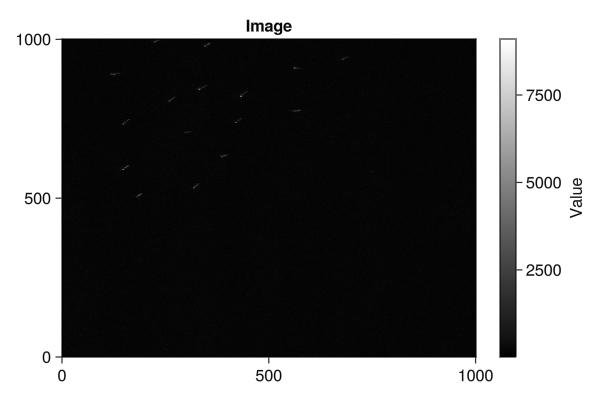

GLMakie.Screen(...)

In [3]:

# Create a figure with an image plot and a colorbar
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image")
im = image!(ax, test_img.data[1][4000:5000,4000:5000], colormap = :greys, colorrange = (minimum(test_img.data[1][4000:5000,4000:5000]), maximum(test_img.data[1][4000:5000,4000:5000])))
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)



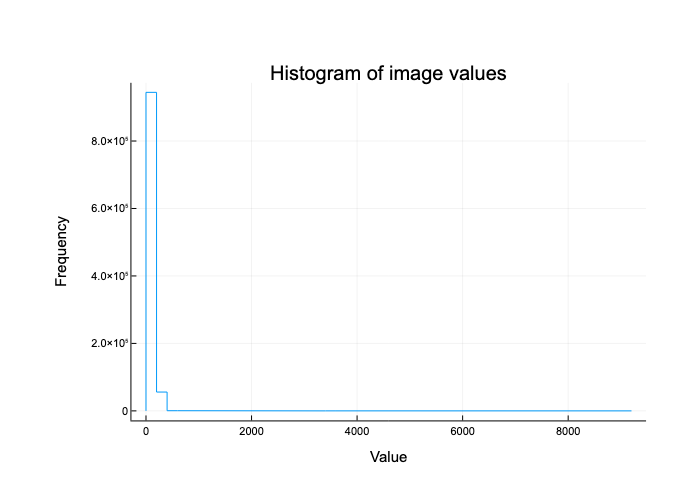

In [4]:
flat_matrix = vec(test_img.data[1][4000:5000,4000:5000])
histogram(flat_matrix, bins=50, xlabel="Value", ylabel="Frequency", title="Histogram of image values", legend=false)

However, it is clear that the images we trained our model on had different intensity distributions, 


We therefore need to apply the same preprocessing steps to the new image as we did to the training data. This includes:


Transformations can be applied using the TransformCompose function

In [5]:
s1_transform = Test_name.Ship_detector.Transformation.TransformCompose([
    Test_name.Ship_detector.Transformation.absolute,
    x -> Test_name.Ship_detector.Transformation.clip_to_valid_range(x, amin=1, amax=65535),
    Test_name.Ship_detector.Transformation.to_linear,
    Test_name.Ship_detector.Transformation.to_db,
    x -> Test_name.Ship_detector.Transformation.two_to_three_channel(x, [1, 1, 1]),
    Test_name.Ship_detector.Transformation.to_float32,
]);


In [6]:
test_img2 = s1_transform(test_img.data);

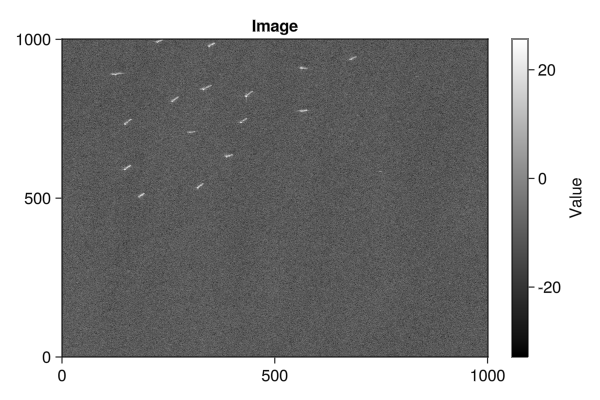

GLMakie.Screen(...)

In [7]:

# Create a figure with an image plot and a colorbar
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image")
im = image!(ax, test_img2[1,4000:5000,4000:5000], colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)



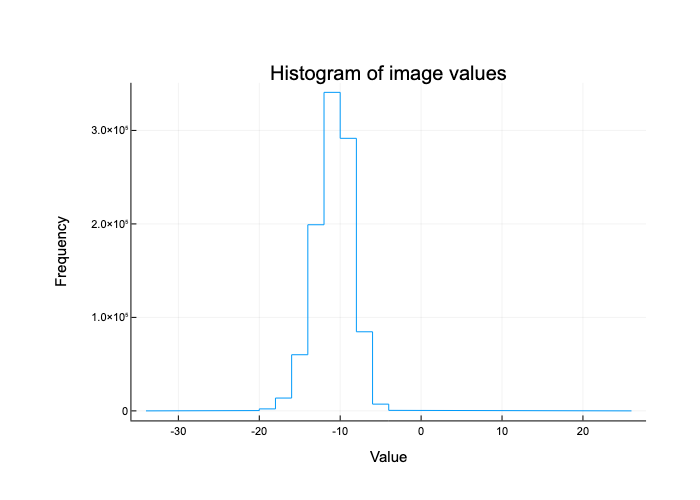

In [8]:
flat_matrix = vec(test_img2[1,4000:5000,4000:5000])
histogram(flat_matrix, bins=50, xlabel="Value", ylabel="Frequency", title="Histogram of image values", legend=false)

## Stage 1: CA-CFAR
Back to [Table of Content](#toc)

In [9]:
input = test_img2[:,4000:5000,4000:5000];

In [10]:
background_window = 41; #pixels in image geometry
guard_window = 31; #pixels in image geometry
probability_for_alarms = 10^(-12);

In [11]:
image_cp_cfar = Test_name.Ship_detector.constant_false_alarm_rate_with_convolution_and_pooling(input[1,:,:],
                                                                                    background_window ÷ 2,
                                                                                    guard_window ÷ 2,
                                                                                    probability_for_alarms);

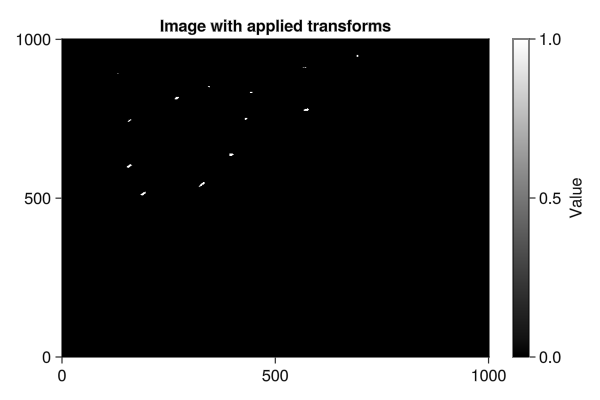

GLMakie.Screen(...)

In [12]:

fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image with applied transforms")
im = image!(ax, image_cp_cfar, colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

In [13]:
image_cp_cfar = Test_name.Ship_detector.binarize_array(image_cp_cfar);
coord_cp = Test_name.Ship_detector.object_locations(convert.(Float64,image_cp_cfar));

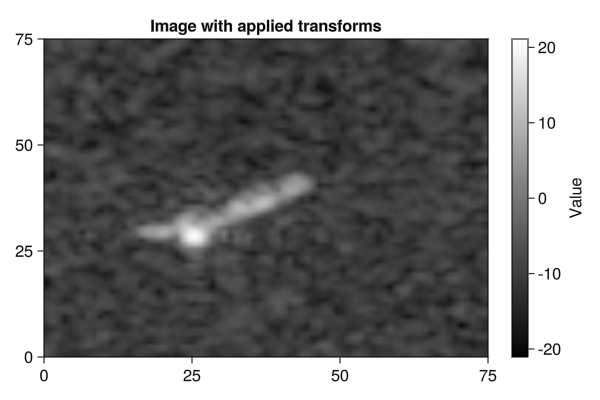

GLMakie.Screen(...)

In [14]:

ix = 10

fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image with applied transforms")
im = image!(ax, input[1,coord_cp[ix][1]-37:coord_cp[ix][1]+37,coord_cp[ix][2]-37:coord_cp[ix][2]+37], colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

# Stage 2

The Sentinel-1 image can be loaded using the Sentinel1GRD function

In [57]:
function min_max_scale(data::Array{Float32,3}; data_max::Float32, data_min::Float32, to_max::Float64, to_min::Float64) where T <: Real
    scaled_data = (data .- data_min) ./ (data_max - data_min) .* (to_max - to_min) .+ to_min
    return scaled_data
end
size(input[:,:,:])

In [32]:
model = Test_name.Ship_detector.Model.Binary_model.load_model("../data/Model/binary_classification/best_model.bson");

┌ Warning: bson model detected. Bson does not work for Julia 1.8.
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/model_util.jl:165


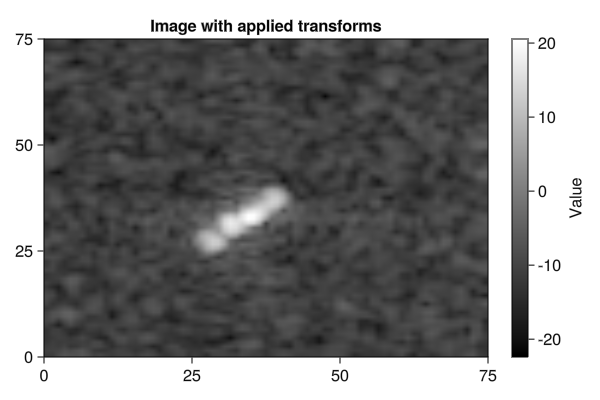

GLMakie.Screen(...)

In [33]:

ix = 1

fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image with applied transforms")
im = image!(ax, input[1,coord_cp[ix][1]-37:coord_cp[ix][1]+37,coord_cp[ix][2]-37:coord_cp[ix][2]+37], colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

In [34]:
inp = input[:,coord_cp[ix][1]-37:coord_cp[ix][1]+37,coord_cp[ix][2]-37:coord_cp[ix][2]+37];
inp = Test_name.Ship_detector.prepare_input(inp);

In [111]:
function prepare_input(matrix)
    # scale so min max is 0 and 1 as in the training data (this is not smart, but just to show how it can be done)
    # normally, there is a global min and max for the whole dataset, but here we use the min and max of the image
    #
    scaled = min_max_scale(matrix, data_max = maximum(matrix[:,:,:]), data_min = minimum(matrix[:,:,:]), to_max = 1.0,to_min =  0.0);
    # reshape to 4D array (batch, height, width, channels)    
    permuted_array = permutedims(scaled[1:2,:,:], [2, 3, 1]);
    reshaped_array = reshape(permuted_array, 75, 75, 1,2);

    return reshaped_array

end

prepare_input (generic function with 1 method)

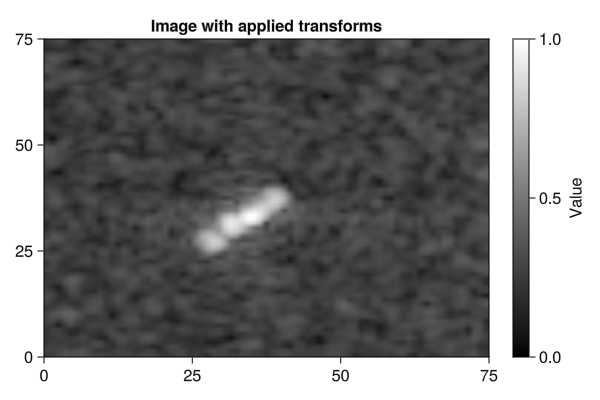

GLMakie.Screen(...)

In [35]:
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image with applied transforms")
im = image!(ax, inp[:,:,1,1], colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

In [37]:
println(Test_name.Ship_detector.Model.Binary_model.classify(input = inp,model = model,threshold = 0.25))

Dict{String, Real}("probability" => 0.74164426f0, "ship" => true)


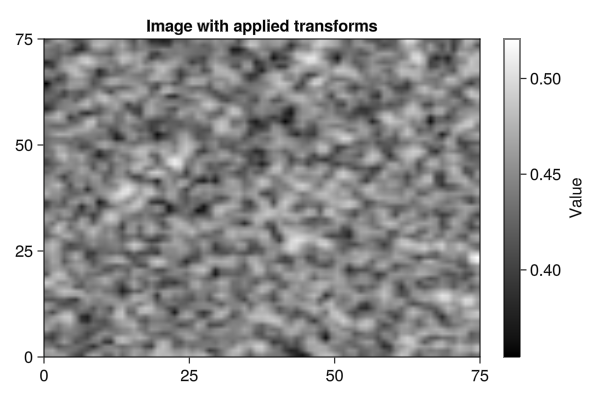

GLMakie.Screen(...)

In [95]:
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image with applied transforms")
im = image!(ax, input[1,500-37:500+37,coord_cp[ix][2]-37:coord_cp[ix][2]+37], colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

In [98]:
inp = input[:,500-37:500+37,coord_cp[ix][2]-37:coord_cp[ix][2]+37];
inp = reshape(inp[1,:,:],75,75,1,1);

println(Test_name.Ship_detector.Model.Binary_model.classify(input = inp,model = model,threshold = 0.25))

Dict{String, Real}("probability" => 0.5873625f0, "ship" => true)
